# CenterNetv2 - Inspect Training Data

Inspect and visualize data loading and pre-processing code.

In [1]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")
sys.path.append("..")
sys.path.append(ROOT_DIR)  # To find local version of the library
from utils import visualize
from utils.utils import extract_bboxes, resize_mask, resize_image
from CenterNet import log
import CenterNet as net
from coco import CocoConfig, CocoDataset

%matplotlib inline

## Configurations

Run one of the code blocks below to import and load the configurations to use.

In [2]:
import coco

# MS COCO Dataset
cocoConfig = coco.CocoConfig()
COCO_DIR = ROOT_DIR + "/coco2014"  # TODO: enter value here
print(COCO_DIR)
cocoConfig.display()

/home/oem/Documents/PyCharm/coco2014

Configurations:
AUGMENT                        False
AUGMENTATION                   None
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FUSION                         DLA
GPU_COUNT                      1
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MAX_GT_INSTANCES               50
MEAN_PIXEL                     [123.7 11

## Dataset

In [3]:
# Load dataset
dataset = coco.CocoDataset()
dataset.load_coco(cocoConfig, COCO_DIR, "train", class_ids=[2,3])

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

loading annotations into memory...
Done (t=7.26s)
creating index...
index created!
Image Count: 10009
Class Count: 2
  0. bicycle                                           
  1. car                                               


## Display Vector Mask Samples
Load and display images and vector masks.

(640, 480, 3)
<class 'tuple'>
(512, 512, 2)
final mask
(512, 512, 4)
unique_class_ids
mask max value:  16.0 .min:  0.0
(512, 512, 2)
top_ids:  [1]
class_id:  1
dimention is:  [0 1]
join class map
(512, 512)
class_id:  -1
dimention is:  []
join class map
(512, 512)
class_id:  -1
dimention is:  []
join class map
(512, 512)
class_id:  -1
dimention is:  []
join class map
(512, 512)
(512, 512, 3)
255
0
(512, 512)
16.0
0.0
(512, 512)
16.0
0.0
(512, 512)
16.0
0.0
(512, 512)
16.0
0.0


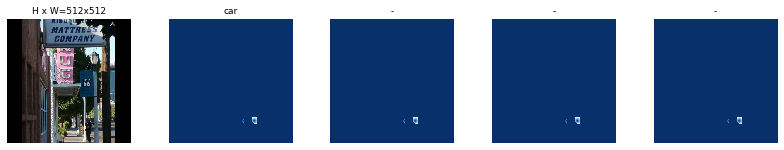

(495, 640, 3)
<class 'tuple'>


ValueError: need at least one array to concatenate

In [5]:
image_ids = np.random.choice(dataset.image_ids, 2)
for image_id in image_ids:
    image, image_meta, class_ids, bbox, mask, gt_y, gt_x, vector_mask = dataset.prepare_image(image_id, cocoConfig)
    visualize.display_top_vector_masks(image, vector_mask, class_ids, dataset.class_names)

## Data Generator and Model
create trainset provider and CenterNetv2 model

()
----loss---- Tensor("cent_loss/add_8:0", shape=(), dtype=float32)
----loss---- Tensor("cent_loss/add_24:0", shape=(), dtype=float32)
----loss---- Tensor("cent_loss/add_40:0", shape=(), dtype=float32)
----loss---- Tensor("cent_loss/add_56:0", shape=(), dtype=float32)
center_loss:  Tensor("Shape:0", shape=(0,), dtype=int32)


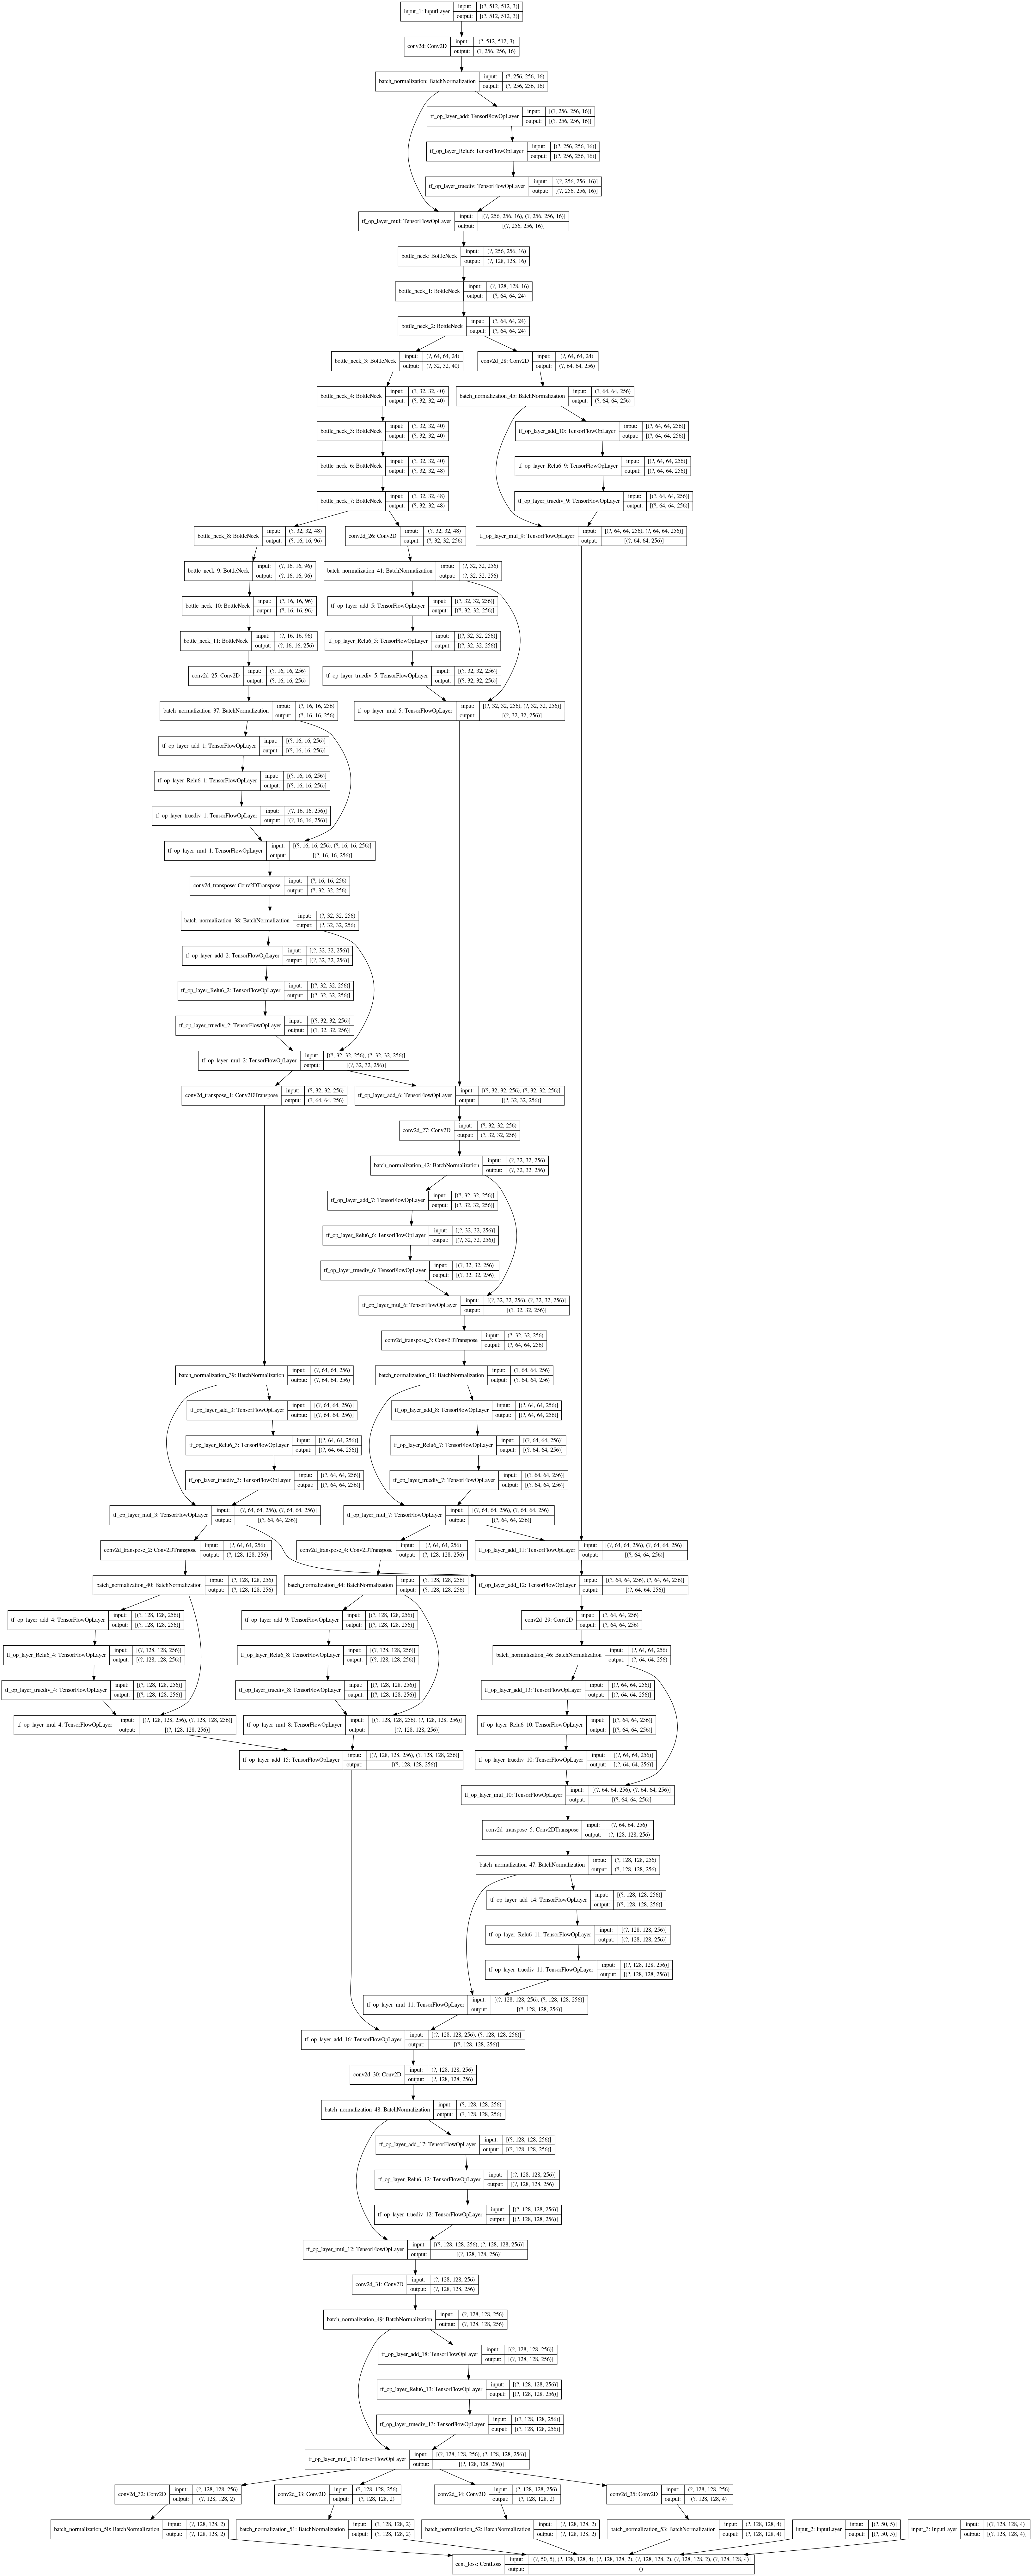

In [4]:
import tensorflow as tf
train_gen = dataset.get_batch_generator(batch_size=4)

trainset_provider = {
    'data_shape': [512, 512, 3],
    'num_train': 10009,
    'num_val': 0,                                         # not used
    'train_generator': None,
    'val_generator': None                                 # not used
}

CenterNetConfig = {
    'mode': 'train',                                       # 'train', 'test'
    'data_format': 'channels_last',
    'fusion': 'DLA',
    'input_size': 512,
    'num_classes': 2,
    'weight_decay': 1e-4,
    'keep_prob': 0.5,                                      # not used
    'batch_size': 4,

    'score_threshold': 0.1,                                 
    'top_k_results_output': 50,


}

centernet = net.CenterNet(CenterNetConfig, trainset_provider)
model = centernet.CenterNetModel
tf.keras.utils.plot_model(model,to_file="model.png",show_shapes=True)
